In [8]:
import pandas as pd
import numpy as np
import csv
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import seaborn as sns
import quantities as pq
from elephant.spike_train_correlation import spike_time_tiling_coefficient
import neo

In [3]:
results_folder = 'Q:\\Personal\\Irina\\projects\\isttc\\results\\monkey\\'

csv_data_file_pfdl = results_folder + 'data_pfdl_fixon_1500ms_fixation.csv'
with open(csv_data_file_pfdl, newline='') as f:
    reader = csv.reader(f)
    sua_list_pfdl = list(reader)
    
n_spike_trains_pfdl = len(sua_list_pfdl)
print('N spike_trains in PFdl fixON {}'.format(n_spike_trains_pfdl))

N spike_trains in PFdl fixON 33018


In [64]:
time_series = np.asarray(sua_list_pfdl[35][3:]).astype(int)
print('time_series {}, \n shape {}'.format(time_series, time_series.shape))

time_series [   8   40   72   90  124  155  161  179  215  231  256  264  293  328
  355  369  380  396  425  452  509  544  567  596  615  632  705  794
  852  908  935 1005 1038 1106 1292 1322 1353 1372 1401 1436 1448 1468
 1490], 
 shape (43,)


#### Calc asf

In [59]:
def calculate_acf_sttc_t(spike_train, n_lags_, acf_lag_ms_, sttc_lag_ms_, rec_length_, verbose=True):
    shift_ms_l = np.linspace(acf_lag_ms_, acf_lag_ms_ * n_lags_, n_lags_).astype(int)
    if verbose:
        print('shift_ms_l {}'.format(shift_ms_l))

    spike_train_bin = np.zeros(rec_length)
    spike_train_bin[spike_train] = 1
    if verbose:
        print(spike_train_bin.shape)

    sttc_self_l = []
    # correlate with itself
    spike_train_neo = neo.SpikeTrain(spike_train_ms_int, units='ms', t_start=0, t_stop=len(spike_train_bin))
    sttc_no_shift = spike_time_tiling_coefficient(spike_train_neo, spike_train_neo, dt=sttc_lag_ms_ * pq.ms)
    sttc_self_l.append(sttc_no_shift)

    # correlated shifted signal
    for shift_ms in shift_ms_l:

        spike_train_bin1 = spike_train_bin[shift_ms:]
        spike_train_bin2 = spike_train_bin[:- shift_ms]
        if verbose:
            print('spike_train_bin1 {}, spike_train_bin2 {}'.format(spike_train_bin1.shape, spike_train_bin2.shape))
        
        spike_train_bin1_idx = np.nonzero(spike_train_bin1)[0]
        spike_train_bin2_idx = np.nonzero(spike_train_bin2)[0]
        if verbose:
            print('spike_train_bin1_idx {}'.format(spike_train_bin1_idx))
            print('spike_train_bin2_idx {}'.format(spike_train_bin2_idx))
        
        spike_train_neo_1 = neo.SpikeTrain(spike_train_bin1_idx, units='ms', t_start=0, t_stop=len(spike_train_bin1))
        spike_train_neo_2 = neo.SpikeTrain(spike_train_bin2_idx, units='ms', t_start=0, t_stop=len(spike_train_bin2))
        if verbose:
            print(spike_train_neo_1)
            print(spike_train_neo_2)
        
        sttc_self = spike_time_tiling_coefficient(spike_train_neo_1, spike_train_neo_2, dt=sttc_lag_ms_ * pq.ms)
        sttc_self_l.append(sttc_self)

    return sttc_self_l

In [65]:
n_lags = 10
acf_lag_ms = 50
sttc_lag_ms = 25
rec_length = 1500

sttc_self_my = calculate_acf_sttc_t(time_series, n_lags, acf_lag_ms, sttc_lag_ms, rec_length, verbose=True)

shift_ms_l [ 50 100 150 200 250 300 350 400 450 500]
(1500,)
spike_train_bin1 (1450,), spike_train_bin2 (1450,)
spike_train_bin1_idx [  22   40   74  105  111  129  165  181  206  214  243  278  305  319
  330  346  375  402  459  494  517  546  565  582  655  744  802  858
  885  955  988 1056 1242 1272 1303 1322 1351 1386 1398 1418 1440]
spike_train_bin2_idx [   8   40   72   90  124  155  161  179  215  231  256  264  293  328
  355  369  380  396  425  452  509  544  567  596  615  632  705  794
  852  908  935 1005 1038 1106 1292 1322 1353 1372 1401 1436 1448]
[  22   40   74  105  111  129  165  181  206  214  243  278  305  319
  330  346  375  402  459  494  517  546  565  582  655  744  802  858
  885  955  988 1056 1242 1272 1303 1322 1351 1386 1398 1418 1440] ms
[   8   40   72   90  124  155  161  179  215  231  256  264  293  328
  355  369  380  396  425  452  509  544  567  596  615  632  705  794
  852  908  935 1005 1038 1106 1292 1322 1353 1372 1401 1436 1448] ms
spik

In [66]:
sttc_self_my

[1.0,
 0.5146294094714979,
 0.24375708296366824,
 0.006421749416236072,
 0.12696291030852697,
 -0.06538243355217045,
 -0.0071456759499379865,
 0.10821413591107674,
 0.08513996833946116,
 0.6298007391933151,
 -0.058762788935202745]

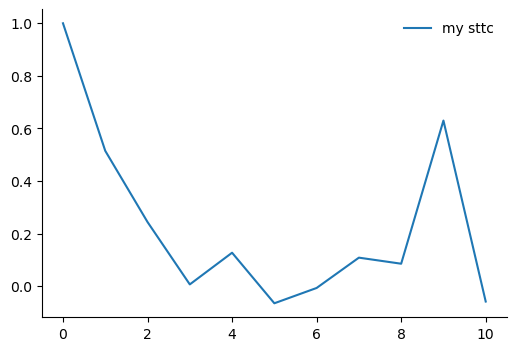

In [67]:
fig, axes = plt.subplots(1,1, figsize=(6,4))

t_lags = np.linspace(0,10,10+1)

axes.plot(t_lags, sttc_self_my, label='my sttc')

axes.legend(frameon=False)

sns.despine()